# Lamprey Transcriptome Analysis: Gene Model Overlap Notebook

```
Camille Scott [camille dot scott dot w @gmail.com] [@camille_codon]

camillescott.github.io

Lab for Genomics, Evolution, and Development
Michigan State University
```

## About

Explores consensus between assembled transcripts and existing lamprey gene models, using the `gtf_to_genes` library.

    assembly version: lamp10

    assembly program: Trinity
    
    gtf model versin: 7.0.75
    
There is another script in this directory called `petmar-gtf-overlap.py` which loads the database and does the `apply` function to query overlaps for each hit, as those operations take a very long time (these are a definite target for optimization).

In [1]:
!echo $PWD

/work/2015-petMarSB/notebooks


## Contents

1. [Libraries](#Libraries) 
* [Data Loading](#Data-Loading)
* [Matplotlib RC Settings](#Matplotlib-RC-Settings)
* [Existing Gene Models](#Existing-Gene-Models)
     1. [Interval Query Initialization](#Interval-Query-Initialization)
     * [Utility Functions](#Utility-Functions)
     * [Results](#Results)

## Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from libs import *
%run -i common.ipy

** Using data resources found in ../resources.json
** Using config found in ../config.json
/home/camille/miniconda/envs/bio/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/camille/miniconda/envs/bio/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
from bx.intervals.intersection import Interval, Intersecter

In [8]:
from IPython.html.widgets import interactive, RadioButtonsWidget
from IPython.display import display
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [10]:
import gffutils

In [11]:
import pyprind

In [13]:
import intervaltree as itree
import intervaltree_bio as itreebio

In [15]:
store = pd.HDFStore(wdir('{}.store.h5'.format(prefix)), complib='zlib', complevel=5)

## Data Loading

In [16]:
lamp10_db = screed.ScreedDB(wdir(resources_df.filename['lamp10']))
lamp00_db = screed.ScreedDB(wdir(resources_df.filename['petMar2_cdna']))

In [17]:
tpm_df = store['tpm_df']

In [18]:
blast_panel = store['blast_panel']
blast_df = store['blast_df']

In [19]:
store['putative_df'].novel.sum()

172630

In [20]:
blast_df.sum()

Myxinidae_pep      8029
braFlo_pep        72771
danRer_pep        85734
homSap_pep        84339
musMus_pep        84234
petMar2          524555
petMar2_cdna      56055
petMar2_cds       55187
petMar2_ncrna      1111
petMar2_pep       76678
dtype: int64

In [21]:
lamp00_pM_df = peasoup.blast.blast_to_df(wdir('{}.fa.x.{}.db.tsv'.format('petMar2.cdna', 'petMar2.fa')))

In [22]:
lamp10_pM_df = peasoup.blast.blast_to_df(wdir('{}.fasta.x.{}.db.tsv'.format('lamp10', 'petMar2.fa')))

## Matplotlib RC Settings

In [23]:
%pylab inline
from matplotlib import rc_context
tall_size = (8,16)
norm_size = (12,8)
mpl_params = {'figure.autolayout': True,
               'axes.titlesize': 24,
               'axes.labelsize': 16,
               'ytick.labelsize': 14,
               'xtick.labelsize': 14
               }
sns.set(style="white", palette="Paired", rc=mpl_params)
#sns.set_palette("Paired", desat=.6)
b, g, r, p = sns.color_palette("muted", 4)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [24]:
%config InlineBackend.close_figures = False

## Existing Gene Models

### Interval Query Initialization

First, load the GTF file into a DataFrame. We define a custom parser for the `attributes` column to split on semicolons and load the data into a dictionary, as these fields are non-uniform within the same file.

The GTF/GFF standard is defined here: http://useast.ensembl.org/info/website/upload/gff.html?redirect=no

In [25]:
# TODO: Add this file to resources.json
gtf_file = wdir(resources_df.ix['petMar2_gtf'].filename)

In [26]:
def attr_col_func(col):
    d = {}
    for item in col.strip(';').split(';'):
        pair = item.strip().split(' ')
        #print pair
        d[pair[0]] = pair[1].strip('"')
    return d

In [27]:
gtf_df = pd.read_table(gtf_file, delimiter='\t', skiprows=4, header=False, 
                       names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'],
                       converters={'attributes': attr_col_func})

In [28]:
gtf_df.set_index('seqname', inplace=True)

In order to overlap analysis with the gene models, we'll create interval trees to query against the gene models. This is a dictionary of interval trees, keyed by genome contig ID.

The interval tree implementation is provided by the python `intervaltree` library: https://github.com/chaimleib/intervaltree

In [70]:
CUTOFF = 0.9

In [29]:
377.0 / len(db.genome_db['GL501259'].sequence)

NameError: name 'db' is not defined

In [141]:
lamp10_pM_df[lamp10_pM_df.sseqid == 'GL501259']

,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
c349657_g1_i5,GL501259,82.76,377,52,9,405,771,7720,8093,2.000000e-86,324


In [140]:
lamp10_pM_df.groupby('sseqid').count()

,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
sseqid,,,,,,,,,,
GL476328,5522,5522,5522,5522,5522,5522,5522,5522,5522,5522
GL476329,6379,6379,6379,6379,6379,6379,6379,6379,6379,6379
GL476330,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616
GL476331,3322,3322,3322,3322,3322,3322,3322,3322,3322,3322
GL476332,3011,3011,3011,3011,3011,3011,3011,3011,3011,3011
GL476333,4646,4646,4646,4646,4646,4646,4646,4646,4646,4646
GL476334,3263,3263,3263,3263,3263,3263,3263,3263,3263,3263
GL476335,9422,9422,9422,9422,9422,9422,9422,9422,9422,9422
GL476336,3461,3461,3461,3461,3461,3461,3461,3461,3461,3461


In [136]:
lamp10_pM_df

,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
c534414_g1_i1,GL477458,99.44,179,1,0,15,193,59873,59695,1.000000e-87,326.0
c534508_g1_i1,GL487923,100.00,214,0,0,1,214,8038,7825,8.000000e-109,396.0
c534069_g1_i1,GL476614,99.52,210,1,0,1,210,444050,444259,7.000000e-105,383.0
c534741_g1_i1,GL482427,99.51,203,1,0,1,203,5744,5542,5.000000e-101,370.0
c534445_g1_i1,GL478305,99.58,239,1,0,1,239,15267,15029,6.000000e-121,436.0
c533911_g1_i1,GL476654,100.00,76,0,0,1,76,233524,233599,4.000000e-32,141.0
c534213_g1_i1,GL476534,100.00,199,0,0,1,199,884468,884270,2.000000e-100,368.0
c534470_g1_i1,GL476360,99.77,439,1,0,1,439,213592,214030,0.000000e+00,806.0
c534474_g1_i1,GL476949,98.05,256,5,0,15,270,86248,85993,1.000000e-123,446.0
c534731_g1_i1,GL480914,99.55,220,1,0,1,220,46531,46312,2.000000e-110,401.0


In [31]:
tr = Intersecter()

In [34]:
from bx import intervals

In [35]:
intervals.IntervalTree.find

In [55]:
class TranscriptIntervalDB(object):
    '''
    Store interval databases of:
    
    1) The GTF models: subdivide all GTF features by assembly contig, then store each contig's features in a
       separate interval database accessible through a dict
    2) The BLAST results of the transcripts against the genome from which the GTF models are derived. These are also
       stored in a dictional of interval databases keyed by contig id, with the intervals induced by the subject coords
    
    '''
    
    def __init__(self, gtf_df, blast_df, transcriptome_fn, genome_fn):
        
        try:
            self.transcriptome_db = screed.ScreedDB(transcriptome_fn)
        except ValueError as e:
            screed.read_fasta_sequences(transcriptome_fn)
            self.transcriptome_db = screed.ScreedDB(transcriptome_fn)
        self.transcriptome_fn = transcriptome_fn
        
        try:
            self.genome_db = screed.ScreedDB(genome_fn)
        except ValueError as e:
            screed.read_fasta_sequences(genome_fn)
            self.genome_db = screed.ScreedDB(genome_fn)
        self.genome_fn = genome_fn
        
        self.gtf_db = {}
        
        gtf_bar = pyprind.ProgBar(len(gtf_df), stream=1, title='Building GTF interval trees')
        for n, (key, row) in enumerate(gtf_df.iterrows()):
            gtf_bar.update()
            if key not in self.gtf_db:
                self.gtf_db[key] = itree.IntervalTree()
            start = row.start
            end = row.end
            if start == end:
                end += 1
            data = row.to_dict()
            self.gtf_db[key][start:end] = data
        
        self.blast_subject_db = {}
        self.blast_query_db = {}
        blast_bar = pyprind.ProgBar(len(blast_df), stream=1, title='Building BLAST interval trees')
        for subject, group in blast_df.groupby('sseqid'):
            for query, row in group.iterrows():
                blast_bar.update()
                
                if subject not in self.blast_subject_db:
                    self.blast_subject_db[subject] = itree.IntervalTree()
                
                if query not in self.blast_query_db:
                    self.blast_query_db[query] = itree.IntervalTree()
                
                start = min(row.sstart, row.send)
                end = max(row.sstart, row.send)
                if start == end:
                    end += 1
                data = row.to_dict()
                self.blast_subject_db[subject][start:end] = data
                
                start = min(row.qstart, row.qend)
                end = max(row.qstart, row.qend)
                if start == end:
                    end += 1
                self.blast_query_db[query][start:end] = data


    def bases_covered(self, seq_id):
        
        def get_total(tree):
            total = 0
            tree = tree.copy()
            tree.merge_overlaps()
            for iv in tree:
                total += iv.length()
            return total
        
        if seq_id in self.transcriptome_db:
            if seq_id in self.blast_query_db:
                return get_total(self.blast_query_db[seq_id])
            else:
                return 0

        if seq_id in self.genome_db:
            if seq_id in self.blast_subject_db:
                return get_total(self.blast_subject_db[seq_id])
            else:
                return 0
                    
        raise IndexError('No sequence named {seq_id} in transcriptome or genome.'.format(**locals()))
    
    def transcriptome_covered_dist(self, subset=None):
        
        if subset is not None:
            keys = set(subset)
        else:
            keys = self.transcriptome_db.iterkeys()
        
        bar = pyprind.ProgBar(len(keys), stream=1, 
                              title='Building dist of transcript homology coverage')
        
        dist = []
        for name in keys:
            bar.update()
            b_covered = self.bases_covered(name)
            dist.append(float(b_covered) / len(self.transcriptome_db[name]))
        
        return dist

    def transcriptome_covered(self, subset=None):
        
        if subset is not None:
            keys = set(subset)
        else:
            keys = self.transcriptome_db.iterkeys()
        
        bar = pyprind.ProgBar(len(keys), stream=1, 
                              title='Calculating total transcript homology coverage')
        
        b_covered = 0
        b_total = 0
        for name in keys:
            bar.update()
            b_covered += self.bases_covered(name)
            b_total += len(self.transcriptome_db[name])
        
        return float(b_covered) / b_total, b_covered, b_total

In [56]:
db = TranscriptIntervalDB(gtf_df.ix['GL476399'], lamp10_pM_df[lamp10_pM_df.sseqid == 'GL476399'],
                         wdir(resources_df.filename['lamp10']), wdir(resources_df.filename['petMar2']))

Building GTF interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 0.154 sec
Building BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 9.389 sec


In [157]:
db = TranscriptIntervalDB(gtf_df, lamp10_pM_df, 
                          wdir(resources_df.filename['lamp10']), wdir(resources_df.filename['petMar2']))

Building GTF interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 54.861 sec
Building BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 2086.846 sec


In [57]:
db.transcriptome_covered(set(lamp10_pM_df[lamp10_pM_df.sseqid == 'GL476399'].index))

Calculating total transcript homology coverage
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 2.639 sec


(0.36903142757454266, 1940823, 5259235)

In [147]:
db.calc_covered('GL501259')

0.04527248452482097

### Utility Functions

Given a genome contig and a range, get the appropriate interval tree and find overlapping intervals. Return the DataFrame indices for matching features.

In [24]:
def describe_overlap(qstart, qend, istart, iend, delta=2):
    qlen = qend - qstart
    ilen = iend - istart
    
    if qstart == istart and qend == iend:
        return 'exact', qlen, 1.0
    
    elif qstart >= istart:
        if qend <= iend:
            return 'contained', qlen, 1.0
        else:
            olen = iend - qstart
            return 'overlaps', olen, float(olen) / qlen
    else:
        if qend <= iend:
            olen = qend - istart
            return 'overlaps', olen, float(olen) /qlen
        else:
            return 'contains', ilen, 1.0

In [25]:
# Tests!
assert describe_overlap(5,10,0,15) == ('contained', 5, 1.0)
assert describe_overlap(0,15,5,10) == ('contains', 5, 1.0)
assert describe_overlap(0,10,5,15) == ('overlaps', 5, .5)
assert describe_overlap(5,15,0,10) == ('overlaps', 5, .5)
assert describe_overlap(0,10,0,10) == ('exact', 10, 1.0)

In [26]:
def get_overlap_rows(seqname, start, end, db, overlaps):
    try:
        tree = db[seqname]
    except Exception as e:
        #print >>sys.stderr, 'No interval tree for sequence', seqname, e
        return []
    # Turns out the intervaltree requires (min,max) style coordinates
    rows = []
    for interval in tree[min(start,end):max(start,end)]:
        ix, feature = interval.data
        rows.append(ix)
        overlaps.append(describe_overlap(min(start, end), max(start, end), interval.begin, interval.end) + (feature, ))
        
    return rows

In [27]:
def get_overlaps(df, db, block_size=5000):
    bar = pyprind.ProgBar(len(df) / block_size, stream=1)
    
    df['features'] = None
    overlaps = []
    for block_start in range(0,len(df), block_size):
        bar.update()
        df.ix[block_start:block_start+block_size, 'features'] = \
            df.ix[block_start:block_start+block_size].apply(
            lambda row: get_overlap_rows(row.sseqid, row.sstart, row.send, db, overlaps), axis=1)
    
    odf = pd.DataFrame(overlaps, columns=['overlap_type', 'length', 'percent', 'feature'])
    return odf

In [28]:
def quantify_overlaps(df, gtf_df=gtf_df):
    df['tr'] = df.index
    df.sort(columns=['tr', 'sseqid'], inplace=True)
    
    overlapped_rows = set()
    df.apply(lambda row: overlapped_rows.update(row.features), axis=1)
    
    stats_srs = gtf_df.ix[list(overlapped_rows)].groupby(by='feature').count().source / \
               gtf_df.groupby(by='feature', axis=0).count().source
    stats_srs = stats_srs.append(pd.Series(float(len(overlapped_rows)) / len(gtf_df), index=['all']))
    
    for feature, perc in stats_srs.iteritems():
        print '{:.2f}% of {:s} features overlapped'.format(perc * 100.0, feature)
    return stats_srs

### Results

First, let's check lamp00 as a baseline.

In [35]:
lamp00_overlaps = get_overlaps(lamp00_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 16.920 sec


In [36]:
lamp00_stats_srs = quantify_overlaps(lamp00_pM_df)

91.98% of CDS features overlapped
96.27% of UTR features overlapped
89.69% of exon features overlapped
79.88% of gene features overlapped
95.00% of start_codon features overlapped
98.04% of stop_codon features overlapped
81.35% of transcript features overlapped
89.93% of all features overlapped


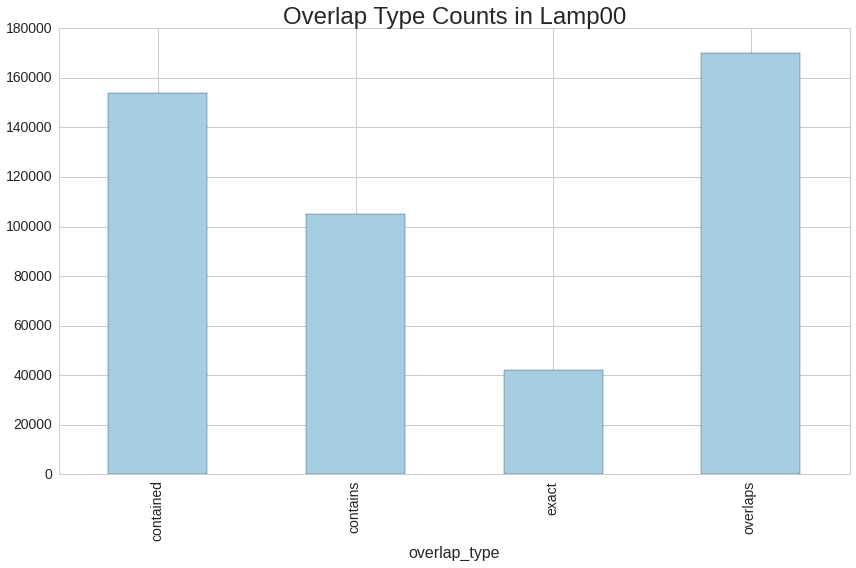

/home/camille/w/2015-petMarSB/notebooks/lamp00_overlap_type_counts.svg

In [44]:
with FigManager('lamp00_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp00_overlaps[lamp00_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp00')
FileLink('lamp00_overlap_type_counts.svg')

Looks alright; now for our assembly.

In [38]:
lamp10_overlaps = get_overlaps(lamp10_pM_df, petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 250.054 sec


In [39]:
lamp10_stats_srs = quantify_overlaps(lamp10_pM_df)

89.22% of CDS features overlapped
95.55% of UTR features overlapped
88.95% of exon features overlapped
92.96% of gene features overlapped
85.05% of start_codon features overlapped
90.81% of stop_codon features overlapped
93.42% of transcript features overlapped
89.60% of all features overlapped


In [ ]:
lamp10_pM_df['features'] = None
lamp10_hom_overlaps = get_overlaps(lamp10_pM_df[blast_df.musMus_pep & blast_df.homSap_pep & blast_df.danRer_pep], petMar2_idb)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 99.686 sec


In [ ]:
lamp10_hom_stats_srs = quantify_overlaps(lamp10_pM_df)

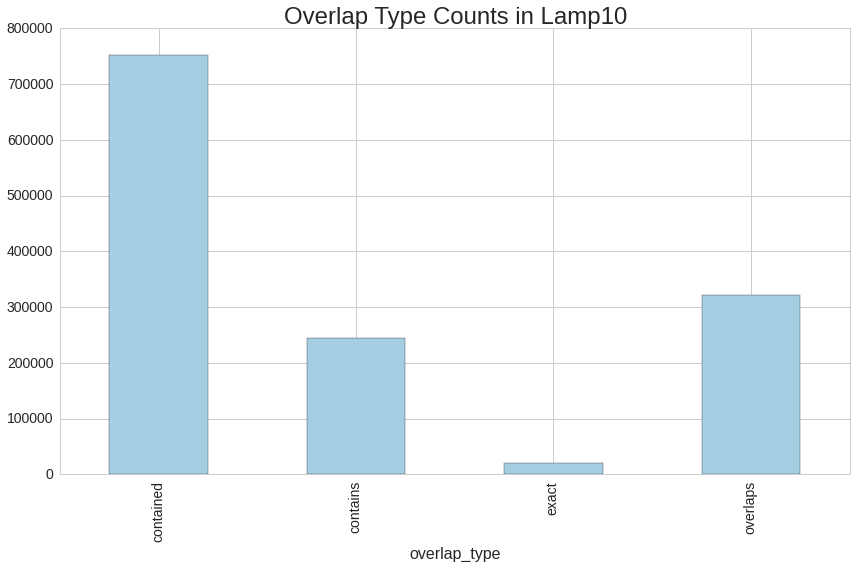

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_type_counts.svg

In [45]:
with FigManager('lamp10_overlap_type_counts', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.feature.isin(['exon', 'CDS', 'gene'])].\
        groupby('overlap_type').count().length.plot(kind='bar', fig=fig, ax=ax)
    ax.set_title('Overlap Type Counts in Lamp10')
FileLink('lamp10_overlap_type_counts.svg')

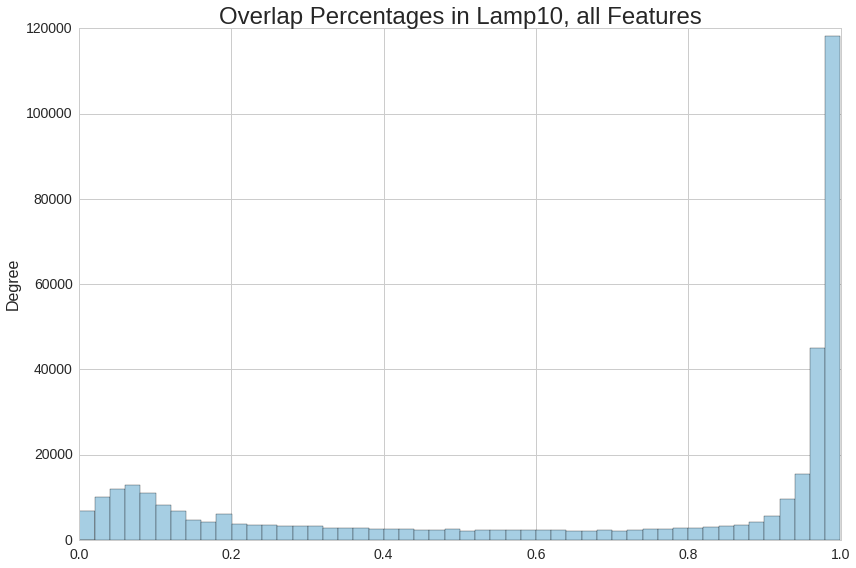

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_all.svg

In [46]:
with FigManager('lamp10_overlap_percentages_all', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[lamp10_overlaps.overlap_type == 'overlaps'].percent.plot(kind='hist', fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, all Features')
FileLink('lamp10_overlap_percentages_all.svg')

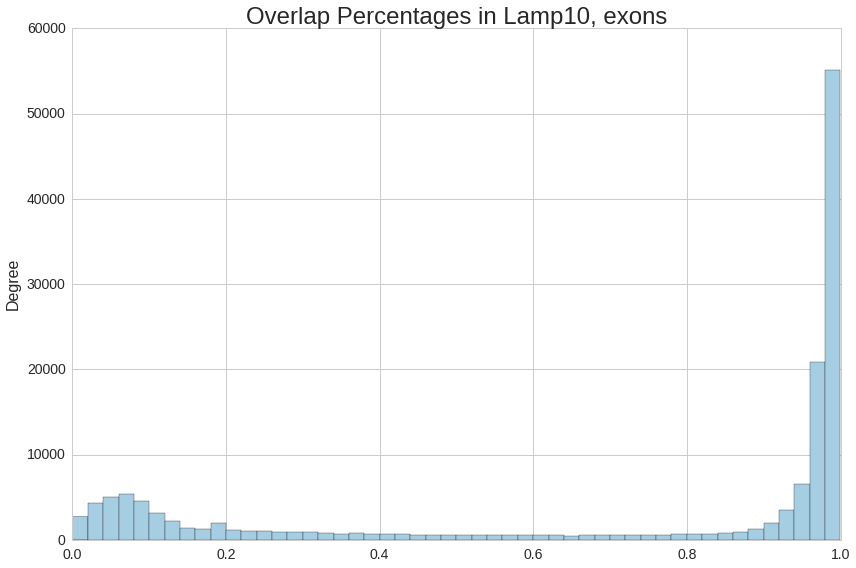

/home/camille/w/2015-petMarSB/notebooks/lamp10_overlap_percentages_exons.svg

In [47]:
with FigManager('lamp10_overlap_percentages_exons', figsize=norm_size, show=True) as (fig, ax):
    lamp10_overlaps[(lamp10_overlaps.overlap_type == 'overlaps') & \
                    (lamp10_overlaps.feature == 'exon')].percent.plot(kind='hist', 
                                                                                             fig=fig, ax=ax, bins=50)
    ax.set_title('Overlap Percentages in Lamp10, exons')
FileLink('lamp10_overlap_percentages_exons.svg')

TODO
1. Normalize vs. amount of genome covered by features
2. Use lamp00 as control for this method X
3. Pull out overlapped for more comparison X
4. Do again with only transcripts mapping to genome + other and do same process
5. Graph align old dna, new dna; transcripts
6. CEGMA 

In [150]:
store.close()

In [63]:
t = itree.IntervalTree()

In [45]:
t[0:5] = 'a'
t[3:8] = 'b'

In [46]:
t

IntervalTree([Interval(0, 5, 'a'), Interval(3, 8, 'b')])

In [62]:
t

IntervalTree([Interval(1, 202, sseqid      GL477774
pident         98.02
length           202
mismatch           4
gapopen            0
qstart             1
qend             202
sstart          7066
send            6865
evalue         2e-95
bitscore         351
Name: c423249_g1_i1, dtype: object)])

In [56]:
lamp10_pM_df.ix['c423249_g1_i1']

,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
c423249_g1_i1,GL477774,98.02,202,4,0,1,202,7066,6865,2.000000e-95,351
c423249_g1_i1,GL480428,93.56,202,13,0,1,202,9476,9677,2.000000e-80,302
c423249_g1_i1,GL479112,91.58,202,17,0,1,202,9775,9574,8.000000e-74,279
c423249_g1_i1,GL484021,91.58,202,16,1,1,202,4149,3949,3.000000e-73,278
c423249_g1_i1,GL481484,91.04,201,18,0,1,201,169036,169236,1.000000e-71,272
c423249_g1_i1,GL482931,89.11,202,22,0,1,202,11304,11103,2.000000e-65,252


In [67]:
for key, row in lamp10_pM_df.ix['c423249_g1_i1'].iterrows():
    start = min(row.qstart, row.qend)
    end = max(row.qstart, row.qend)
    t[start:end] = row.sseqid

In [69]:
t.merge_overlaps()

In [70]:
t

IntervalTree([Interval(1, 202)])

In [77]:
db = {}

In [78]:
bar = pyprind.ProgBar(len(lamp10_pM_df), stream=1, title='Building BLAST interval trees')
for query, row in lamp10_pM_df.iterrows():
    bar.update()
    subject = row.sseqid
    if query not in db:
        db[query] = itree.IntervalTree()
    if subject not in db:
        db[subject] = itree.IntervalTree()
    
    qstart = min(row.qstart, row.qend)
    qend = max(row.qstart, row.qend)
    db[query][qstart:qend] = subject
    
    sstart = min(row.sstart, row.send)
    send = max(row.sstart, row.send)
    db[subject][sstart:send] = query

Building BLAST interval trees
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 863.877 sec


In [80]:
db['c423249_g1_i1']

IntervalTree([Interval(1, 201, 'GL481484'), Interval(1, 202, 'GL477774'), Interval(1, 202, 'GL479112'), Interval(1, 202, 'GL480428'), Interval(1, 202, 'GL482931'), Interval(1, 202, 'GL484021')])

In [81]:
db['GL481484']

IntervalTree([Interval(122, 159, 'c324467_g1_i1'), Interval(122, 159, 'c324467_g1_i2'), Interval(191, 341, 'c337672_g2_i1'), Interval(191, 341, 'c337672_g2_i2'), Interval(191, 404, 'c348062_g1_i2'), Interval(252, 404, 'c348062_g1_i1'), Interval(259, 668, 'c351170_g2_i2'), Interval(319, 668, 'c351170_g2_i3'), Interval(472, 889, 'c349309_g3_i1'), Interval(593, 634, 'c379082_g1_i1'), Interval(1105, 1141, 'c257255_g1_i1'), Interval(1260, 1358, 'c350846_g3_i1'), Interval(1439, 1481, 'c345161_g1_i5'), Interval(1502, 1575, 'c364369_g4_i1'), Interval(1502, 1576, 'c364369_g2_i1'), Interval(1502, 1576, 'c364369_g2_i2'), Interval(1591, 1739, 'c42347_g1_i1'), Interval(2658, 2704, 'c351836_g2_i1'), Interval(3069, 3199, 'c42347_g1_i1'), Interval(3167, 3199, 'c341733_g1_i1'), Interval(3378, 3415, 'c352823_g3_i3'), Interval(3378, 3564, 'c352823_g3_i2'), Interval(3378, 3569, 'c352823_g3_i1'), Interval(3573, 3886, 'c360935_g5_i1'), Interval(3660, 3868, 'c364099_g8_i1'), Interval(3943, 4158, 'c192354_g1_